**Соберём данные о курсе биткоина с марта по апрель 2023**

Представим их в виде таблицы с указанием минимума, максимума и цены закрытия за период в 1 минуту.
Для асинхронного сбора данных используется библиотека aiohttp.

In [3]:
!pip install -U aiohttp

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import datetime
import pandas as pd
from tqdm import trange
import aiohttp
import asyncio


async def get_binance_df(client, symbol, interval, start_time, end_time, lim=1000):
    """
    Функция для обработки данных с Binance в pandas dataframe.
    """
    # формируем URL для запроса
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&startTime={start_time}&endTime={end_time}&limit={lim}'
    # отправляем GET-запрос
    async with client.get(url) as response:
        # преобразуем ответ в формат JSON
        data = await response.text()
        #print(data)
    # выводим данные
    df = pd.read_json(data)
    df = df.drop(columns=[1, 5, 6, 7, 8, 9, 10, 11])
    df = df.rename(columns={0: 'time', 2: 'max', 3: 'min', 4: 'close'})
    # преобразуем столбец 'Open time' к типу datetime
    df["time"] =  pd.to_datetime(df['time'], unit='ms')
    return df

async def get_fin_df(start_time, end_time, symbol='BTCUSDT', interval='1m'):
    # задаем параметры запроса
    lim = 1000 # Максимальное число запросов
    start_time = int(start_time.timestamp())*1000
    end_time = int(end_time.timestamp())*1000
    
    tasks = []
    dt_ = 45000000
    async with aiohttp.ClientSession() as session:
        for i in range(start_time, end_time, dt_):
            tasks.append(get_binance_df(session, symbol, interval, i, i+dt_, lim))
        res = await asyncio.gather(*tasks)
    return pd.concat(res, ignore_index=True)

start_time = datetime.datetime(2023,3,1,3,0,0) # начальная дата периода, за который нужны данные
end_time = datetime.datetime(2023,4,9,23,59,59) # конечная дата периода, за который нужны данные 

df = await get_fin_df(start_time, end_time)
df.to_csv("btcusd04_2023_1m.csv") # Запись данных за март в минутных интервалах
df

,time,max,min,close
0,2023-03-01 00:00:00,23154.70,23130.25,23143.73
1,2023-03-01 00:01:00,23153.45,23139.15,23139.15
2,2023-03-01 00:02:00,23160.00,23138.54,23157.00
3,2023-03-01 00:03:00,23162.16,23153.85,23158.53
4,2023-03-01 00:04:00,23178.71,23158.14,23178.71
...,...,...,...,...
57742,2023-04-10 02:26:00,28300.00,28296.48,28300.00
57743,2023-04-10 02:27:00,28304.25,28299.99,28304.24
57744,2023-04-10 02:28:00,28304.82,28302.78,28302.79
57745,2023-04-10 02:29:00,28303.35,28302.78,28303.34


Соберём статистические данные в 5-минутном интервале.

In [5]:
def transform_to_N_min(df, N=10):
    df_ = pd.DataFrame({"time": [i for i in df["time"].values[::N]], "max":0, "min": 0, "close": 0})
    for i in range(0, df.shape[0], N):
        df_.loc[i//N, "max"] = df.loc[i:i+N, "close"].max()
        df_.loc[i//N, "min"] = df.loc[i:i+N, "close"].min()
        try:
            df_.loc[i//N, "close"] = df.loc[i+N, "close"]
        except:
            df_.loc[i//N, "close"] = df["close"].values[-1]
    return df_

df = transform_to_N_min(df, 5)
df

,time,max,min,close
0,2023-03-01 00:00:00,23178.71,23139.15,23172.93
1,2023-03-01 00:05:00,23172.93,23120.06,23123.50
2,2023-03-01 00:10:00,23163.97,23123.50,23163.97
3,2023-03-01 00:15:00,23186.39,23163.97,23186.39
4,2023-03-01 00:20:00,23201.88,23184.30,23184.30
...,...,...,...,...
11545,2023-04-10 02:09:00,28302.99,28297.32,28302.98
11546,2023-04-10 02:14:00,28302.98,28274.07,28288.61
11547,2023-04-10 02:19:00,28296.49,28288.61,28296.49
11548,2023-04-10 02:24:00,28304.24,28296.49,28303.34


Приведём данные к виду, который будет удобен для проведения последующего анализа.

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

scaler = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))
def prepare_dataframe(df):
    df_ = df[:]
    df_["time"] = list(range(df["time"].shape[0]))
    X = scaler.fit_transform(df_[["time", "max", "min"]])
    y = scaler_y.fit_transform(df_[["close"]])
    return X, y

X_dataset, y_dataset = prepare_dataframe(df)
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.3, shuffle=False)

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Sequential

2023-04-11 16:34:58.409796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 16:34:58.540138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-11 16:34:58.540163: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-11 16:34:58.572998: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-11 16:34:59.395878: W tensorflow/stream_executor/platform/de

Создание модели нейронной сети и её обучение на первых 70% данных.

In [8]:
model = Sequential()
model.add(LSTM(X_train.shape[1], return_sequences=True, input_shape=[X_train.shape[1], 1]))
model.add(LSTM(X_train.shape[1], return_sequences=False))
model.add(Dense(1, activation="linear"))
model.compile(optimizer='adam', loss = 'mse')

model.summary()
model.fit(X_train, y_train, batch_size = 1, epochs=20)

2023-04-11 16:35:00.163764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-11 16:35:00.163799: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-11 16:35:00.163822: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (archlinux): /proc/driver/nvidia/version does not exist
2023-04-11 16:35:00.164040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 3)              60        
                                                                 
 lstm_1 (LSTM)               (None, 3)                 84        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
8085/8085 [==============================] - 32s 4ms/step - loss: 0.0066
Epoch 2/20
8085/8085 [==============================] - 30s 4ms/step - loss: 4.5905e-05
Epoch 3/20
8085/8085 [==============================] - 29s 4ms/step - loss: 2.9980e-05
Epoch 4/20
8085/8085 [==============================] - 30s 4m

Тестирование и сохранение весов.

In [9]:
model.evaluate(X_test, y_test)
model.save("model.h5")

109/109 [==============================] - 1s 2ms/step - loss: 6.9617e-06


Выведем график курса криптовалюты (в нормированном виде).

109/109 [==============================] - 1s 2ms/step


Text(0.5, 1.0, 'Price history (2023.03.01-2023.04.9)')

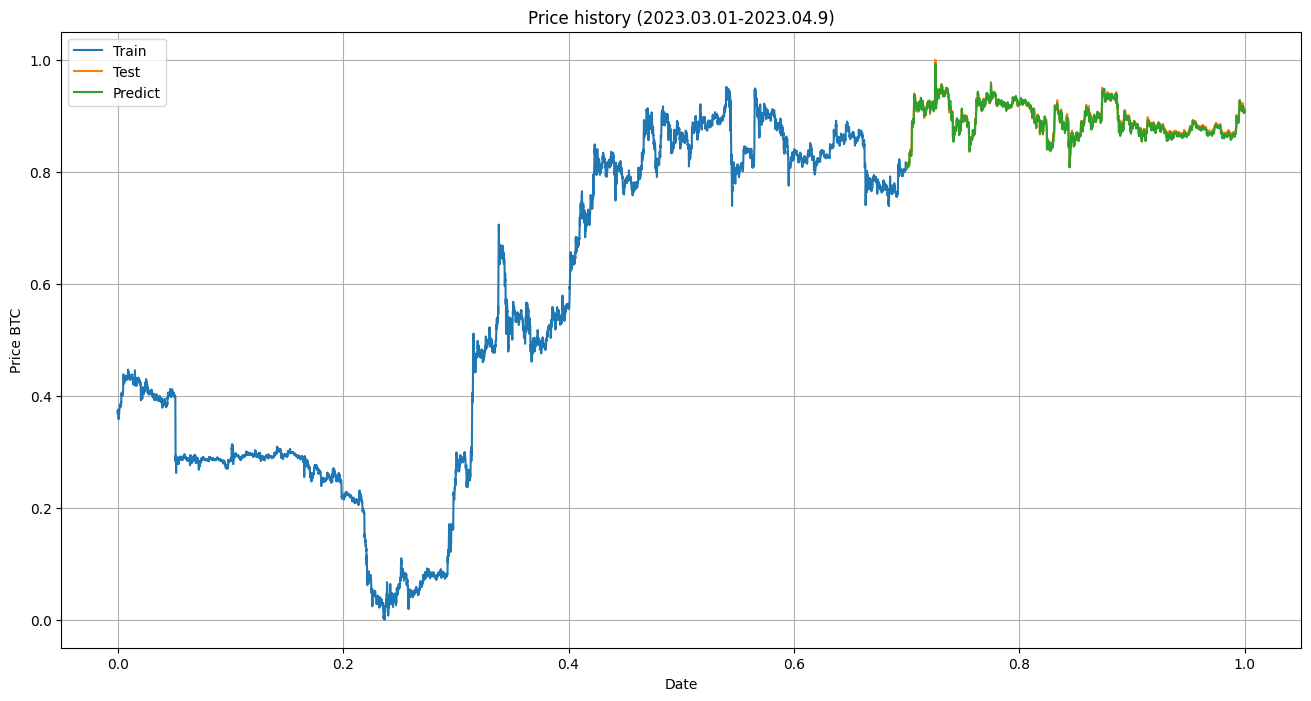

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize = (16,8))
ax.grid(True)
ax.plot(X_train[:,0], y_train, label= "Train")
ax.plot(X_test[:,0], y_test, label="Test")
ax.plot(X_test[:,0], model.predict(X_test), label="Predict")
ax.legend()
plt.xlabel("Date")
plt.ylabel("Price BTC")
plt.title("Price history (2023.03.01-2023.04.9)")

Теперь рассмотрим поведение модели на актуальных данных и с другим временным интервалом (в 1 минуту).

In [44]:
df2 = await get_fin_df(datetime.datetime(2023,4,11,8,0,0), datetime.datetime(2023,4,11,15,0,0))
df2

,time,max,min,close
0,2023-04-11 05:00:00,30109.02,30103.14,30103.96
1,2023-04-11 05:01:00,30109.01,30100.00,30109.01
2,2023-04-11 05:02:00,30109.01,30100.00,30100.01
3,2023-04-11 05:03:00,30100.01,30099.99,30099.99
4,2023-04-11 05:04:00,30113.66,30095.01,30095.77
...,...,...,...,...
530,2023-04-11 13:50:00,30166.20,30158.25,30163.89
531,2023-04-11 13:51:00,30163.90,30152.42,30159.00
532,2023-04-11 13:52:00,30159.01,30142.95,30142.95
533,2023-04-11 13:53:00,30153.66,30127.22,30144.12


In [45]:
X, y = prepare_dataframe(df2)
X

array([[0.        , 0.70708299, 0.79595641],
       [0.00187266, 0.70705099, 0.7877117 ],
       [0.00374532, 0.70705099, 0.7877117 ],
       ...,
       [0.99625468, 0.86701005, 0.90048576],
       [0.99812734, 0.84989443, 0.85918341],
       [1.        , 0.82564463, 0.89665223]])

Строим график и сравниваем предсказанные значения с реальными данными.

15/15 [==============================] - 0s 2ms/step - loss: 6.3041e-04


Text(0.5, 1.0, 'Price history (2023.10.04: 11:00:00-13:50:00)')

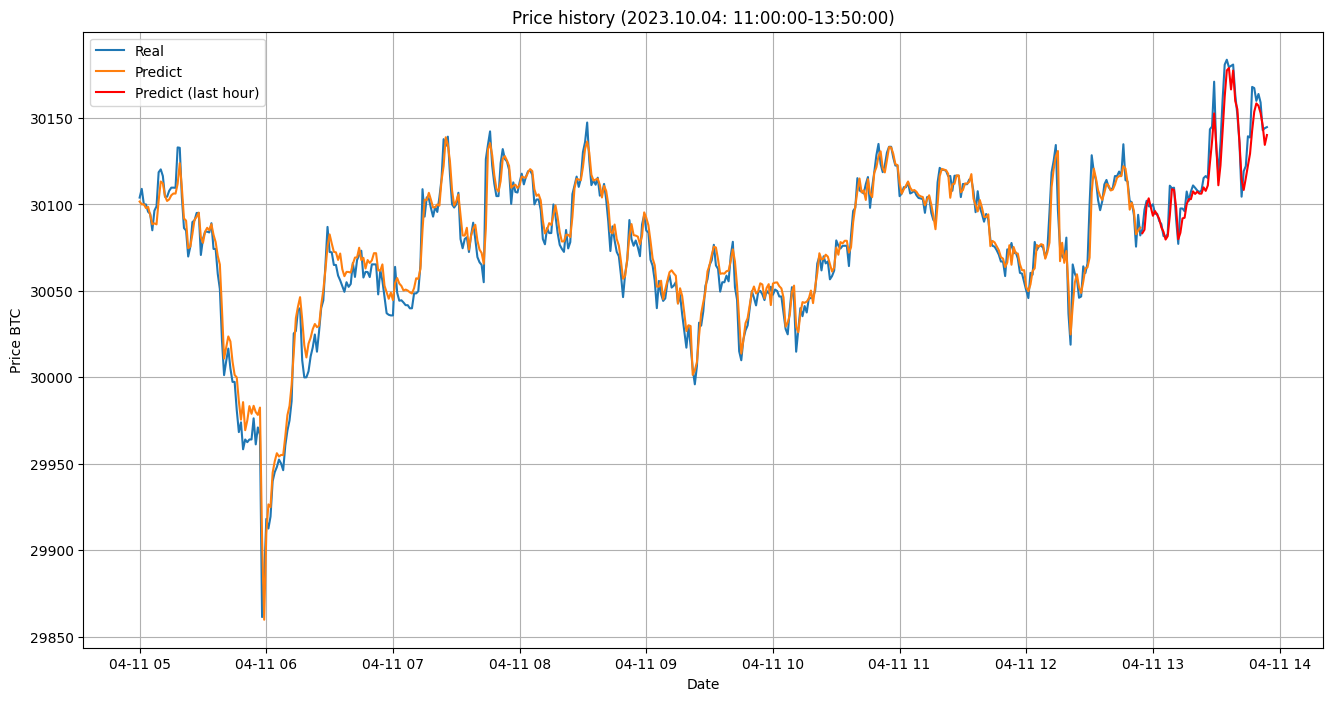

In [50]:
fig, ax = plt.subplots(1, figsize = (16,8))
pred = scaler_y.inverse_transform(model.predict(X))
model.evaluate(X[:-60], y[:-60])
ax.grid(True)
ax.plot(df2["time"].values, df2["close"].values, label="Real")
ax.plot(df2["time"].values[:-60], pred[:-60], label="Predict")
ax.plot(df2["time"].values[-60:], pred[-60:], color="r", label="Predict (last hour)")
ax.legend()
plt.xlabel("Date")
plt.ylabel("Price BTC")
plt.title("Price history (2023.10.04: 11:00:00-13:50:00)")